## Clustering

Let's now retrieve the clustering embeddings from the chromadb and perform clustering on them.

In [1]:
import chromadb

client = chromadb.PersistentClient(path="./chroma_db")
collection = client.get_collection("nomic_clustering_v1")

### Let's retrieve the embeddings and the words along with the class, division, and section from the chromadb and create a dataframe with them.


In [2]:
import pandas as pd

# Retrieve the embeddings, words, and metadata
words = collection.get(include=["embeddings", "documents"])['documents']
embeddings = collection.get(include=["embeddings", "documents"])['embeddings']
metadata = collection.get(include=["embeddings", "documents", "metadatas"])['metadatas']

# Create a dataframe with the embeddings and the words
clustering_df = pd.DataFrame({'word': words, 'embedding': embeddings})

# Add the class, division, and section from metadata to the dataframe
clustering_df['class'] = [md['class'] for md in metadata]
clustering_df['division'] = [md['division'] for md in metadata]
clustering_df['section'] = [md['section'] for md in metadata]

clustering_df

,word,embedding,class,division,section
0,Existence,"[-0.000911712646484375, -0.007648468017578125,...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
1,Inexistence,"[0.006107330322265625, 0.0400390625, -0.014945...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
2,Consanguinity,"[0.0592041015625, 0.006099700927734375, -0.005...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,RELATION
3,Trisection,"[0.0188751220703125, 0.01338958740234375, -0.0...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,NUMBER
4,Innocence,"[0.046478271484375, 0.022918701171875, -0.0289...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
...,...,...,...,...,...
1052,Knave,"[-0.004238128662109375, 0.0267791748046875, -0...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
1053,Disinterestedness,"[0.0007662773132324219, 0.0261688232421875, -0...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
1054,Selfishness,"[0.0265655517578125, 0.0660400390625, -0.03088...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
1055,Virtue,"[0.041351318359375, 0.0128173828125, -0.041320...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS


Let's have a look at the class distribution.

In [3]:
clustering_df['class'].value_counts()

class
WORDS RELATING TO THE VOLUNTARY POWERS             228
WORDS EXPRESSING ABSTRACT RELATIONS                193
WORDS RELATING TO THE SENTIENT AND MORAL POWERS    184
WORDS RELATING TO THE INTELLECTUAL FACULTIES       163
WORDS RELATING TO MATTER                           147
WORDS RELATING TO SPACE                            142
Name: count, dtype: int64

In [4]:
n_classes = clustering_df['class'].nunique()

We can see that the classes are well not balanced.

## We will use the KMeansConstrained algorithm to perform the clustering.

The KMeansConstrained algorithm is a modified version of the KMeans algorithm that allows for a minimum and maximum number of words in each cluster, 
in order for the clusters to be 'balanced'.
We will use the `KMeansConstrained` algorithm from the `k_means_constrained` library to perform the clustering.

In [5]:
from k_means_constrained import KMeansConstrained
from sklearn.cluster import KMeans

model = KMeansConstrained(n_clusters=n_classes, size_min=140, size_max=245,
                          n_init=100, max_iter=500, random_state=22, n_jobs=-1)  #22 min=140, max=245


We will use the embeddings to fit the model, and then we will add the cluster labels to the dataframe,
where we will use `vstack` to convert the list of embeddings into a matrix.

In [6]:
import numpy as np

matrix = np.vstack(clustering_df.embedding.values)
matrix.shape

(1057, 768)

We can now fit the model and add the cluster labels to the dataframe.

In [7]:
model.fit(matrix)
labels = model.labels_
clustering_df["Cluster"] = labels

We can now create a function to visualize the clusters in a 2D space using t-SNE.

t-distributed stochastic neighbor embedding (t-SNE) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map.

We will use the `TSNE` algorithm from the `sklearn.manifold` library to perform the t-SNE and then we will use the `matplotlib` library to visualize the clusters.

The following code was inspired by the following [OpenAI notebook](https://cookbook.openai.com/examples/clustering)

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def draw_clusters(clustering_df, title):
    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
    vis_dims2 = tsne.fit_transform(matrix)

    x = [x for x, y in vis_dims2]
    y = [y for x, y in vis_dims2]

    for category, color in enumerate(["purple", "green", "red", "blue", "orange", "yellow"]):
        xs = np.array(x)[clustering_df.Cluster == category]
        ys = np.array(y)[clustering_df.Cluster == category]
        plt.scatter(xs, ys, color=color, alpha=0.3)

        avg_x = xs.mean()
        avg_y = ys.mean()

        plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
    plt.title(title)
    plt.show()

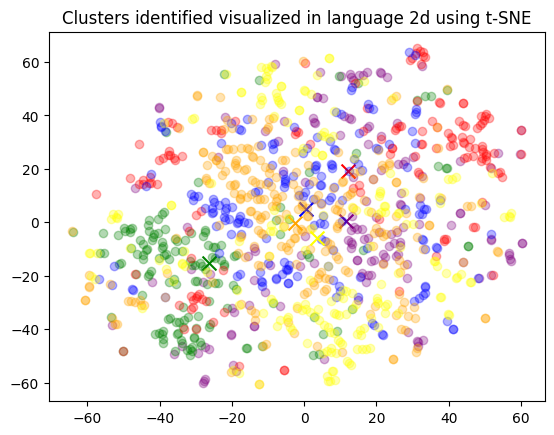

In [9]:
draw_clusters(clustering_df, "Clusters identified visualized in language 2d using t-SNE")

In [10]:

#
#tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
#vis_dims2 = tsne.fit_transform(matrix)
#
#x = [x for x, y in vis_dims2]
#y = [y for x, y in vis_dims2]
#
#for category, color in enumerate(["purple", "green", "red", "blue", "orange", "yellow"]):
#    xs = np.array(x)[clustering_df.Cluster == category]
#    ys = np.array(y)[clustering_df.Cluster == category]
#    plt.scatter(xs, ys, color=color, alpha=0.3)
#
#    avg_x = xs.mean()
#    avg_y = ys.mean()
#
#    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
#plt.title("Clusters identified visualized in language 2d using t-SNE")

Let's now count the number of elements in each cluster.

In [10]:
clustering_df.Cluster.value_counts()

Cluster
4    245
5    202
3    170
1    149
0    149
2    142
Name: count, dtype: int64

### Let's now try and give a name to each cluster based on the words that are in it.

For this task we will use the latest mistral-v.0.2 LLM model self-hosted using Ollama.
More specifically, we will give the model the words in each cluster and ask it to give a category name similar to the 
class names of the roget thesaurus. 
In order to use the model, we will use the `ChatOllama` class from the `langchain_community` library.
We will set the temperature to 0.0 to get the most likely categories and we will use the GPU if it is available.

In [22]:
from langchain_community.chat_models import ChatOllama
import torch

llm_model = 'mistral'
device = "cuda" if torch.cuda.is_available() else "cpu"

# We set the temperature to 0.0 to get the most likely categories and we use the mistral model
llm = ChatOllama(model=llm_model, temperature=0.0, device=device)

Next we will define the prompt that we will use to get the categories from the model.

In [23]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template(
    "Provide a category that classifies all these words about what they express (only into one category) : {words}"
    "similar with the naming of the following categories: {categories} along with a small explanation of why you chose to name the category in this way. At the end of the explanation, you must write the category again inside <<>>. For example: <<category>>")

Then we will create a chain that will use the prompt, the llm model and the output parser to get the categories from the model.

In [24]:
from langchain_core.output_parsers import StrOutputParser

chain = prompt | llm | StrOutputParser()

Now let us get the words along with their classes and division and sections from the json file we created earlier for later use.

In [9]:
import json

with open("hierarchy.json", "r") as f:
    categories = json.load(f)

Let's convert the above into a dataframe.

In [16]:
#import pandas as pd
#
#def json_to_df(categories, class_name=None, division_name='N/A'):
#    df = pd.DataFrame()
#    for key, value in categories.items():
#        # Check if the current key is a class
#        if 'divisions' in value and 'sections' in value:
#            class_df = json_to_df(value['divisions'], class_name=key)
#            section_df = json_to_df(value['sections'], class_name=key, division_name='N/A')  # Reset division for sections
#            df = pd.concat([df, class_df, section_df], ignore_index=True)
#        elif isinstance(value, dict):  # This is a division or a section
#            if 'sections' in value:  # This is a division
#                sub_df = json_to_df(value['sections'], class_name=class_name, division_name=key)
#            else:  # This is a section without a division
#                sub_df = json_to_df(value, class_name=class_name, division_name=division_name)
#            df = pd.concat([df, sub_df], ignore_index=True)
#        else:  # This is the actual list of words
#            for word in value:
#                new_row = pd.DataFrame({
#                    "word": [word],
#                    "class": [class_name],
#                    "division": [division_name],
#                    "section": [key],
#                })
#                df = pd.concat([df, new_row], ignore_index=True)
#    return df
#
#
#categories_df = json_to_df(categories)
#
## Displaying the first few rows of the DataFrame
#categories_df

In [17]:
# Merge the df with the categories_df
#df_both = clustering_df.merge(categories_df, on="word", how="inner")
#df_both

In [18]:
# Drop duplicates of the words
#df_both = df_both.drop_duplicates(subset=['word'])
#df_both

Having the above setup, we can now get the categories for each cluster.

The following code was inspired by the following [OpenAI notebook](https://cookbook.openai.com/examples/clustering).

The idea is to use the words in each cluster to get the categories from the model
 and we will show 20 words from each cluster after the explanation about why the naming of the category was chosen,
 but here we are using the mistral model instead of the GPT-4 model through the langchain_community library.

In our case we will use the words in each cluster to get the categories from the model.
 and we will show 20 words from each cluster after the explanation about why the naming of the category was chosen.
 
More specifically, we will write the name of the category in the following format: <<category>> at the end of the explanation
in order to easily get it through regex.

In [19]:
import re

# Reading words belonging to each cluster
num_words = 10

# Initialize the list of classes
classes = []

for i in range(6):
    print(f"Cluster {i} Theme:", end=" ")

    words = ",".join(
        clustering_df[clustering_df.Cluster == i]["word"]
        .values
    )

    response = chain.invoke({"words": words, "categories": clustering_df['class'].unique()})
    print(response)

    # Extracting the categories from the response
    pattern = r'<<([^>]*)>>'
    matches = re.finditer(pattern, response)
    # Append extracted class name to the list of classes
    classes.append([match.group(1) for match in matches])
    sample_cluster_rows = clustering_df[clustering_df.Cluster == i]['word'].sample(num_words, random_state=42)
    for j in range(num_words):
        print(sample_cluster_rows.iloc[j], end=", ")
    print()

    print("-" * 100)

Cluster 0 Theme: 

NameError: name 'chain' is not defined

Let's now see the classes that were extracted from the model.

In [20]:
classes

[]

We can see that the model was able to give a category to each cluster based on the words that are in it.

# ! Write about conclusions and comparisons with the roget classes

Now done with the naming of the clusters, we can try and match the extracted classes with the classes from the roget thesaurus.

Let's start by creating a function that will take the extracted classes and the roget classes and will return the most similar roget class for each extracted class
by identifying the closest words to each cluster's centroid.

In [10]:
def clustering_details_optimized(model, maximum_value, df, hierarchy, category_index):
    labels = model.labels_
    unique_labels = set(labels)

    words_in_clusters = {label: df[df['Cluster'] == label]['word'].tolist() for label in unique_labels}

    for cluster, words_in in words_in_clusters.items():
        print(f"Cluster {cluster}: {words_in}")

    unique, counts = np.unique(labels, return_counts=True)
    print(dict(zip(unique, counts)))

    centroids = model.cluster_centers_
    total_count = []

    for i, centroid in enumerate(centroids):
        cluster_embeddings = np.vstack(df[df['Cluster'] == i]['embedding'])

        if cluster_embeddings.shape[1] != centroid.shape[0]:
            print(f"Dimension mismatch: Embeddings have {cluster_embeddings.shape[1]} features, but centroid has {centroid.shape[0]} features.")
            continue

        distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)
        closest_indices = np.argsort(distances)[:maximum_value]
        closest_words = [df.iloc[index]['word'] for index in df[df['Cluster'] == i].index[closest_indices]]

        print(f"Closest words to centroid {i}: {closest_words}")

        count = [0] * len(category_index)

        for word in closest_words:
            for category, content in hierarchy.items():
                if any(word in words for words in content.get('sections', {}).values()):
                    count[category_index[category]] += 1
                    break
                if any(word in words for division_content in content.get('divisions', {}).values() for words in division_content.get('sections', {}).values()):
                    count[category_index[category]] += 1
                    break

        total_count.append(count)

    return total_count


After that, we will define a function that matches the clusters to the classes.

In [11]:
def match_clusters_to_classes_optimized(total_count):
    num_clusters = len(total_count)
    relation = []

    # Create a list of tuples (max_value, cluster_index, class_index)
    max_values_indices = [(max(count), i, count.index(max(count))) if count else (-1, i, -1) for i, count in enumerate(total_count)]

    for _ in range(num_clusters):
        # Find the cluster with the highest max value
        max_cluster = max(max_values_indices, key=lambda x: x[0])
        max_val, max_cluster_idx, max_class_idx = max_cluster

        # Check if there are no more valid clusters
        if max_val == -1:
            break

        # Append the cluster and its matched class
        relation.append([max_cluster_idx, max_class_idx])

        # Invalidate the matched cluster and class
        for i in range(num_clusters):
            if max_class_idx < len(total_count[i]):
                total_count[i][max_class_idx] = -1
            max_values_indices[i] = (max(total_count[i]), i, total_count[i].index(max(total_count[i])) if total_count[i] else -1)

        # Invalidate all classes in the matched cluster
        total_count[max_cluster_idx] = [-1] * len(total_count[max_cluster_idx])
        max_values_indices[max_cluster_idx] = (-1, max_cluster_idx, -1)

    return relation


Lastly, we will define a function that remaps the labels using the relation list we get from the previous function.

In [12]:
def remap_optimized(labels, relation):
    cluster_to_class_map = {cluster: class_ for cluster, class_ in relation}
    return [cluster_to_class_map.get(label, label) for label in labels]


In [10]:
def clustering_details(model, maximum_value , df, hierarchy):
    # Get the cluster labels
    labels = model.labels_

    # Initialize a dictionary to store words in each cluster
    words_in_clusters = {i: [] for i in range(len(set(labels)))}
    # Associate each word with its corresponding cluster label
    for word, label in zip(df['word'].tolist(), df['Cluster'].tolist()):
        words_in_clusters[label].append(word)

    # Print words in each cluster
    for cluster, words_in in words_in_clusters.items():
        print(f"Cluster {cluster}: {words_in}")

    # Print the number of words in each cluster
    unique, counts = np.unique(labels, return_counts=True)
    print(dict(zip(unique, counts)))

    # Get the cluster centers
    centroids = model.cluster_centers_

    total_count = []

    # Find the closest word to each centroid
    for i, centroid in enumerate(centroids):
        # Filter embeddings belonging to the current cluster
        # cluster_embeddings = df['embedding'][labels == i]
        cluster_embeddings = np.vstack(df['embedding'][labels == i])

        # Check and adjust shapes
        if cluster_embeddings.shape[1] != centroid.shape[0]:
            print(
                f"Dimension mismatch: Embeddings have {cluster_embeddings.shape[1]} features, but centroid has {centroid.shape[0]} features.")
            continue  # Skip this iteration

        # Reshape centroid to be a 2D array with one row
        # centroid_reshaped = centroids.reshape(1, -1)

        # Calculate the distance between the centroid and embeddings in the cluster
        distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)

        # Find the indices of the 3 closest embeddings
        closest_indices = np.argsort(distances)[:maximum_value]

        # Retrieve the corresponding words
        closest_words = [df['word'].tolist()[np.where(labels == i)[0][index]] for index in closest_indices]

        # Print the closest words to the centroid
        print(f"Closest words to centroid {i}: {closest_words}")

        # create a list counting the number of times a string appears
        count = [0, 0, 0, 0, 0, 0]

        # Assuming 'closest_words' is a list of words and 'dictionary' is structured as provided
        for word in closest_words:
            found = False
            for category, content in hierarchy.items():
                if found:
                    break
                # Check in divisions first
                for division, division_content in content.get('divisions', {}).items():
                    for section, words in division_content.get('sections', {}).items():
                        if word in words:
                            if category == "WORDS EXPRESSING ABSTRACT RELATIONS":
                                count[0] += 1
                            elif category == "WORDS RELATING TO SPACE":
                                count[1] += 1
                            elif category == "WORDS RELATING TO MATTER":
                                count[2] += 1
                            elif category == "WORDS RELATING TO THE INTELLECTUAL FACULTIES":
                                count[3] += 1
                            elif category == "WORDS RELATING TO THE VOLUNTARY POWERS":
                                count[4] += 1
                            elif category == "WORDS RELATING TO THE SENTIENT AND MORAL POWERS":
                                count[5] += 1
                            found = True
                            break
                    if found:
                        break
                # Check in sections if not found in divisions
                if not found:
                    for section, words in content.get('sections', {}).items():
                        if word in words:
                            if category == "WORDS EXPRESSING ABSTRACT RELATIONS":
                                count[0] += 1
                            elif category == "WORDS RELATING TO SPACE":
                                count[1] += 1
                            elif category == "WORDS RELATING TO MATTER":
                                count[2] += 1
                            elif category == "WORDS RELATING TO THE INTELLECTUAL FACULTIES":
                                count[3] += 1
                            elif category == "WORDS RELATING TO THE VOLUNTARY POWERS":
                                count[4] += 1
                            elif category == "WORDS RELATING TO THE SENTIENT AND MORAL POWERS":
                                count[5] += 1
                            found = True
                            break

        total_count.append(count)
    return total_count

def match_clusters_to_classes(total_count):
    relation = []
    for j in range(len(total_count)):
        max_pos = -1
        max_val = -1
        max_index = -1
        #for each list in total_count, get the index of the maximum value and the maximum value
        for i in range(len(total_count)):
            #print(i, total_count[i].index(max(total_count[i])), max(total_count[i]))
            # i is cluster and index is the closest class
            if max(total_count[i]) > max_val:
                max_val = max(total_count[i])
                max_pos = i
                max_index = total_count[i].index(max(total_count[i]))
        print(max_pos, max_index, max_val)
        # cluster and class+
        relation.append([max_pos, max_index])

        # replace the values in position max_index in each of the lists with -1
        for i in range(len(total_count)):
            total_count[i][max_index] = -1
            #print(total_count[i])
        # replace each element of the list in position max_pos with -1
        for i in range(len(total_count[max_pos])):
            total_count[max_pos][i] = -1

    return relation


def remap(labels, relation):
    # remap the clusters to the classes based on the relation
    # (relation[i][0] is the cluster and relation[i][1] is the class to map to)
    for i in range(len(labels)):
        for j in range(len(relation)):
            if labels[i] == relation[j][0]:
                labels[i] = relation[j][1]
                break

    return labels

In [23]:
import numpy as np

def clustering_details_optimized(model, maximum_value, df, hierarchy):
    labels = model.labels_
    words = df['word'].tolist()
    embeddings = np.vstack(df['embedding'])

    # Efficiently creating words in clusters
    words_in_clusters = {i: [] for i in set(labels)}
    for word, label in zip(words, labels):
        words_in_clusters[label].append(word)

    for cluster, words_in in words_in_clusters.items():
        print(f"Cluster {cluster}: {words_in}")

    unique, counts = np.unique(labels, return_counts=True)
    print(dict(zip(unique, counts)))

    centroids = model.cluster_centers_
    total_count = []

    for i, centroid in enumerate(centroids):
        cluster_embeddings = embeddings[labels == i]
        if cluster_embeddings.shape[1] != centroid.shape[0]:
            print(f"Dimension mismatch: Embeddings have {cluster_embeddings.shape[1]} features, but centroid has {centroid.shape[0]} features.")
            continue

        distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)
        closest_indices = np.argsort(distances)[:maximum_value]
        closest_words = [words[index] for index in closest_indices]

        print(f"Closest words to centroid {i}: {closest_words}")

        count = [0] * 6  # Assuming 6 categories
        for word in closest_words:
            for category_index, (category, content) in enumerate(hierarchy.items()):
                if word_in_hierarchy(word, content):
                    count[category_index] += 1
                    break
        total_count.append(count)

    return total_count

def word_in_hierarchy(word, content):
    for division, division_content in content.get('divisions', {}).items():
        for section, words in division_content.get('sections', {}).items():
            if word in words:
                return True
    for section, words in content.get('sections', {}).items():
        if word in words:
            return True
    return False


def match_clusters_to_classes_optimized(total_count):
    relation = []
    while any(total_count):
        max_val = -1
        max_pos = -1
        max_index = -1
        for i, count_list in enumerate(total_count):
            for j, count in enumerate(count_list):
                if count > max_val:
                    max_val = count
                    max_pos = i
                    max_index = j
        if max_val == -1:
            break

        print(max_pos, max_index, max_val)
        relation.append([max_pos, max_index])

        for count_list in total_count:
            count_list[max_index] = -1
        total_count[max_pos] = [-1] * len(total_count[max_pos])

    return relation

def remap_optimized(labels, relation):
    mapping = {cluster: new_class for cluster, new_class in relation}
    return [mapping.get(label, label) for label in labels]


Now we can use the above functions to get the most similar roget class for each extracted class.

In [11]:
# Set the maximum value to find the closest words to the centroid
MAX_VALUE = 300
#total_count = clustering_details(model, MAX_VALUE, clustering_df, categories)
total_count = clustering_details(model, MAX_VALUE,clustering_df, categories)
relation = match_clusters_to_classes(total_count)
print(relation)
predicted_labels = remap(clustering_df['Cluster'], relation)

Cluster 0: ['Consanguinity', 'Trisection', 'Quadruplication', 'Quadrisection', 'Heterodoxy', 'Judeo-Christian Revelation', 'Pseudo-Revelation', 'Quinquesection', 'Canonicals', 'Plurality', 'Fraction', 'Multitude', 'Correlation', 'Infinity', 'Contingent Duration', 'Chronometry', 'The Present Time', 'Synchronism', 'Futurity', 'Frequency', 'Conversion', 'Reversion', 'Revolution', 'Substitution', 'Interchange', 'Stability', 'Eventuality', 'Similarity', 'Destruction', 'Reproduction', 'Tendency', 'Counteraction', 'Displacement', 'Receptacle', 'Expansion', 'Contraction', 'Interval', 'Variation', 'Contiguity', 'Breadth', 'Filament', 'Summit', 'Parallelism', 'Prototype', 'Inversion', 'Interposition', 'Circumscription', 'Outline', 'Contraposition', 'Symmetry', 'Distortion', 'Angularity', 'Curvature', 'Quantity', 'Convolution', 'Concavity', 'Perforator', 'Quiescence', 'Navigation', 'Transference', 'Direction', 'Deviation', 'Sequence', 'Progression', 'Regression', 'Convergence', 'Divergence', 'Eje

C:\Users\panagiotis\AppData\Local\Temp\ipykernel_16552\3476051570.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[i] = relation[j][1]
C:\Users\panagiotis\AppData\Local\Temp\ipykernel_16552\3476051570.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[i] = relation[j][1]
C:\Users\panagiotis\AppData\Local\Temp\ipykernel_16552\3476051570.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[i] = relation[j][1

In [13]:
def cluster_checking(model, clustering_df, categories):
    MAX_VALUE = 300
    # Extract unique classes and sort them (remove sorted() if sorting is not needed)
    unique_classes = sorted(clustering_df['class'].unique())
    
    # Create a category index by enumerating the sorted unique classes
    category_index = {class_name: index for index, class_name in enumerate(unique_classes)}
    total_count = clustering_details_optimized(model, MAX_VALUE, clustering_df, categories, category_index)
    #total_count = clustering_details_optimized(model, MAX_VALUE, clustering_df, categories)
    relation = match_clusters_to_classes_optimized(total_count)
    print(relation)
    predicted_labels = remap_optimized(clustering_df['Cluster'], relation)
    return predicted_labels

In [14]:
predicted_labels = cluster_checking(model, clustering_df, categories)

Cluster 0: ['Consanguinity', 'Trisection', 'Quadruplication', 'Quadrisection', 'Heterodoxy', 'Judeo-Christian Revelation', 'Pseudo-Revelation', 'Quinquesection', 'Canonicals', 'Plurality', 'Fraction', 'Multitude', 'Correlation', 'Infinity', 'Contingent Duration', 'Chronometry', 'The Present Time', 'Synchronism', 'Futurity', 'Frequency', 'Conversion', 'Reversion', 'Revolution', 'Substitution', 'Interchange', 'Stability', 'Eventuality', 'Similarity', 'Destruction', 'Reproduction', 'Tendency', 'Counteraction', 'Displacement', 'Receptacle', 'Expansion', 'Contraction', 'Interval', 'Variation', 'Contiguity', 'Breadth', 'Filament', 'Summit', 'Parallelism', 'Prototype', 'Inversion', 'Interposition', 'Circumscription', 'Outline', 'Contraposition', 'Symmetry', 'Distortion', 'Angularity', 'Curvature', 'Quantity', 'Convolution', 'Concavity', 'Perforator', 'Quiescence', 'Navigation', 'Transference', 'Direction', 'Deviation', 'Sequence', 'Progression', 'Regression', 'Convergence', 'Divergence', 'Eje

Let's now get the classes in numeric categories and add them to the dataframe.

In [15]:
clustering_df['class_num'] = pd.Categorical(clustering_df['class'])
clustering_df['class_num'] = clustering_df['class_num'].cat.codes
clustering_df['Cluster'] = predicted_labels

With the above setup, we can now compare the extracted classes with the roget classes
by doing a classification report as well as a confusion matrix on the predicted labels and the roget classes.
to see how well the extracted classes match the roget classes.

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Print the classification report
print(classification_report(clustering_df['class_num'], clustering_df['Cluster']))
#print(classification_report(clustering_df['class_num'], predicted_labels))

              precision    recall  f1-score   support

           0       0.40      0.31      0.35       193
           1       0.32      0.44      0.37       147
           2       0.19      0.20      0.19       142
           3       0.27      0.24      0.26       163
           4       0.24      0.22      0.23       184
           5       0.31      0.33      0.32       228

    accuracy                           0.29      1057
   macro avg       0.29      0.29      0.29      1057
weighted avg       0.29      0.29      0.29      1057


In [17]:
# Print the confusion matrix
print(confusion_matrix(clustering_df['class_num'], clustering_df['Cluster']))

[[60 25 33 23 24 28]
 [13 64 37 13  4 16]
 [43 27 28  7  8 29]
 [15 31  9 39 26 43]
 [ 6 21 31 31 41 54]
 [12 34 11 29 67 75]]


#### Conclusion


...

### With the one level clustering done, we can now try to do the two level clustering.

For each remapped label, we will create a new dataframe with the words and the embeddings that belong to that label.
Then we will fit a new KMeans model to the embeddings of each dataframe and get the cluster labels.

In [ ]:
# Create a for loop that performs KMeans clustering on each class  

for i in range(n_classes):
    # Create a new dataframe with the words and the embeddings that belong to the current label
    new_df = clustering_df[clustering_df['Cluster'] == i]
    
    # See if new_df has division
    if new_df['division'].nunique() > 1:
        n_clusters = new_df['division'].nunique()
    else:
        n_clusters = new_df['section'].nunique()

    # Get the embeddings from the new dataframe
    new_matrix = np.vstack(new_df.embedding.values)

    # Fit the KMeans model to the embeddings
    new_model = KMeans(n_clusters=n_clusters[i], n_init=100, max_iter=100, random_state=42)
    new_model.fit(new_matrix)

    # Get the cluster labels
    new_labels = new_model.labels_

    # Add the cluster labels to the new dataframe
    new_df["Cluster"] = new_labels
    print(new_df)
    
    # Add functions to do the same as above